# Denoising OPM Data (M170 data)

## Add toolboxes to your MATLAB path

In [9]:
%% Paths (RS)
fieldtripDir    = '/Users/rseymoue/Documents/scripts/fieldtrip-20191213';
script_dir      = '/Users/rseymoue/Documents/GitHub/analyse_OPMEG';
denoise_dir     = '/Users/rseymoue/Documents/scripts/NoiseTools';
data_dir        = '/Volumes/Robert T5/OPM_data/benchmarking_26_02/';
save_dir        = '/Users/rseymoue/Documents/GitHub/opm_benchmarking_feb_2020/';

% Add Fieldtrip to path
disp('Adding Fieldtrip, NoiseTools and analyse_OPMEG to your MATLAB path');
addpath(fieldtripDir)
ft_defaults;

% Add analyse_OPMEG Scripts to path
addpath(genpath(script_dir));

% Add NoiseTools to path
addpath(denoise_dir)

% cd to save dir
cd(save_dir)

Adding Fieldtrip, NoiseTools and analyse_OPMEG to your MATLAB path


## Read in the data, select relevent channels, downsample to 300Hz and plot PSD

#### Note: Usually you wouldn't downsample at this stage, but for time-saving I did!

the call to "ft_selectdata" took 4 seconds and required the additional allocation of an estimated 1301 MB
the input is raw data with 32 channels and 1 trials
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 1 MB
resampling data
resampling data in trial 1 from 1
original sampling rate = 6000 Hz
new sampling rate = 300 Hz
the call to "ft_resampledata" took 7 seconds and required the additional allocation of an estimated 1459 MB
Calculating PSD for ALL channels


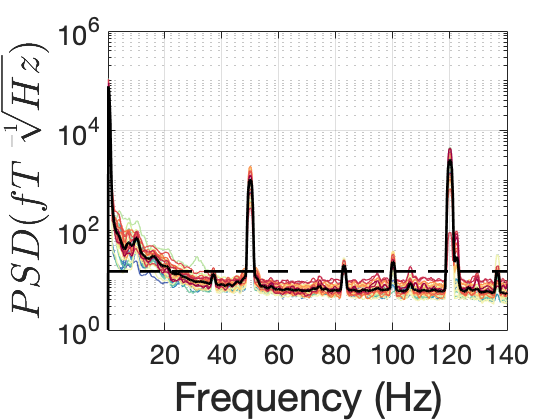

In [10]:
% Read in the raw data using BIDS
cfg             = [];
cfg.folder      = data_dir;
cfg.precision   = 'single';
cfg.bids.task   = 'faces';
cfg.bids.sub    = '002';
cfg.bids.ses    = '001';
cfg.bids.run    = '001';
rawData         = ft_opm_create(cfg);

% Select only OPM channels
cfg             = [];
cfg.channel     = vertcat(ft_channelselection_opm('MEG',rawData),...
    ft_channelselection_opm('MEGREF',rawData));
rawData_MEG     = ft_selectdata(cfg,rawData);

% % Resample to 300Hz to speed things up
cfg             = [];
cfg.resamplefs  = 300;
[rawData_MEG]   = ft_resampledata(cfg, rawData_MEG);

% Plot PSD
cfg                 = [];
cfg.channel         = 'all';
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.2 140];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd(cfg,rawData_MEG);


In the PSD, we can see lots of low-frequency noise (below 2Hz), 50Hz line noise, noise at 120Hz from the opti-track and smaller peaks at 37Hz and 84Hz :(

## Robust Detrending

Please see Cheveigné & Arzounian (2018) https://doi.org/10.1016/j.neuroimage.2018.01.035 for details of this method. It is very similar to other polynomial removal methods, but is also *robust* to sensor railing, and allows the user detrend over overlapping windows in their data.

Here, because we are using overlapping 1 second windows and removing 10 polynomials. This is an unusually small window size, but there is *lots* of low-frequency noise in this particular dataset. Please adjust the cfg.poly_num and cfg.wsize for your own data.

This procedure takes a while, so go make a coffee.


window_size =

   300

 
NoiseTools, version 18-Feb-2020
http://audition.ens.fr/adc/NoiseTools
Please cite relevant methods papers.
 
Detrending...
the input is raw data with 32 channels and 1 trials
> In fixsampleinfo (line 94)
  In ft_datatype_raw (line 147)
  In ft_checkdata (line 268)
  In ft_databrowser (line 294)
detected   0 visual artifacts
the call to "ft_prepare_layout" took 0 seconds and required the additional allocation of an estimated 1 MB
the call to "ft_prepare_layout" took 0 seconds and required the additional allocation of an estimated 0 MB
the call to "ft_databrowser" took 3 seconds and required the additional allocation of an estimated 0 MB


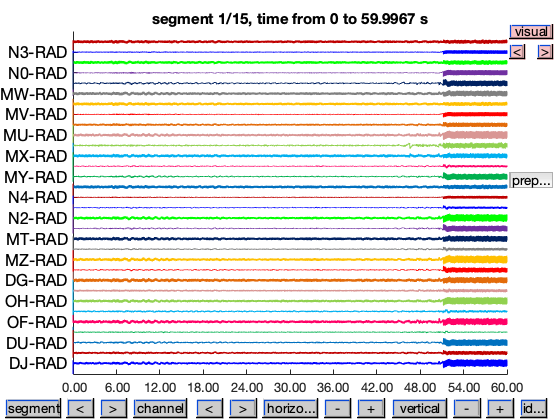

In [14]:
% Detrend
window_size = rawData_MEG.fsample*1;

cfg              = [];
cfg.poly_num     = 10;
cfg.wsize        = window_size;
[rawData_MEG_dt] = ft_robust_detrend(cfg,rawData_MEG);

% Plot the raw data
cfg = [];
cfg.viewmode = 'vertical';
cfg.blocksize = 60;
ft_databrowser(cfg,rawData_MEG_dt);


#### OK not too bad! Let's plot the PSD:

Calculating PSD for ALL channels


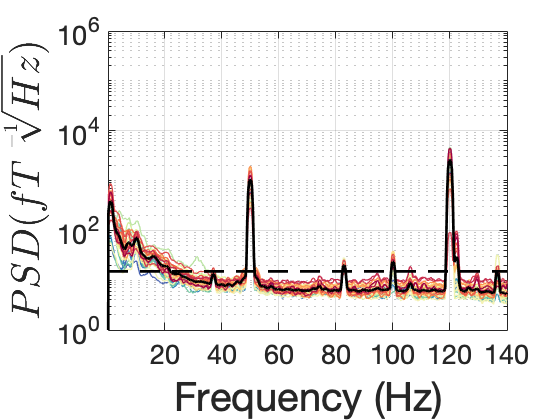

In [15]:
% Plot the PSD
cfg                 = [];
cfg.channel         = 'all';
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.2 140];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd(cfg,rawData_MEG_dt);
ylim([1 1e6]);

#### ... and the shielding factor (ie. comparison between the data before and after detrending)

Calculating PSD for ALL channels
Calculating PSD for ALL channels


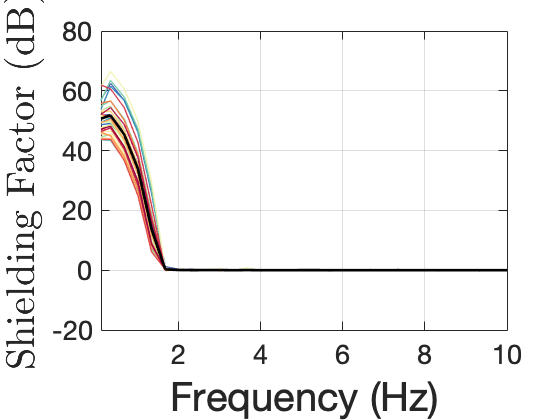

In [16]:
% Plot the Shielding Factor
cfg                 = [];
cfg.channel         = 'all';
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.1 10];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd_compare(cfg,rawData_MEG, rawData_MEG_dt);

#### Great! We've consistently removed the noise below 2Hz

## Synthetic Gradiometry

Here we have opted to filter the data between 1-40Hz and 40-60Hz when performing the synethetic gradiometry. Including frequencies above 60Hz results in sub-optimal results due to the large peak at 120Hz. You could remove this with a notch filter if needed.

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 49 MB
Selected 24 data channels
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 16 MB
Selected  8 reference channels
Filtering reference data:   1Hz -  40Hz ... 
Filtering reference data:  40Hz -  60Hz ... 
Regressin'...
Calculating PSD for ALL channels


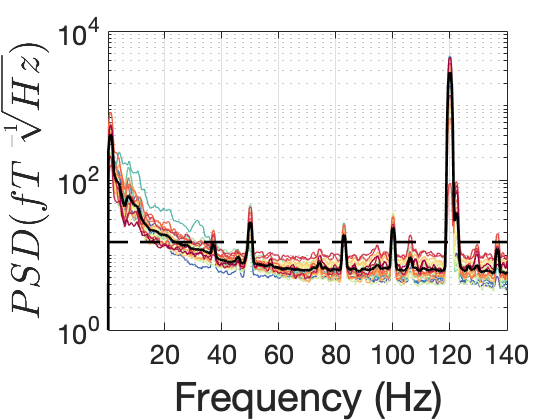

In [26]:
%% Synthetic Gradiometry
cfg = [];
cfg.channel = vertcat(ft_channelselection_opm('MEG',rawData),...
     '-N0-TAN','-N4-TAN','-N3-TAN','-MV-TAN','-N0-RAD','-N4-RAD',...
     '-N3-RAD','-MV-RAD');
cfg.refchannel = ft_channelselection_opm('MEGREF',rawData);
cfg.filter_ref = [1 40; 40 60];
cfg.derivative = 'yes';
cfg.return_all = 'no';
[rawData_MEG_dt_sg] = ft_opm_synth_gradiometer(cfg,rawData_MEG_dt);

cfg                     = [];
cfg.channel             = 'all';
cfg.trial_length        = 3;
cfg.method              = 'tim';
cfg.foi                 = [0.2 140];
cfg.plot                = 'yes';
cfg.plot_legend         = 'no';
pow                     = ft_opm_psd(cfg,rawData_MEG_dt_sg);

## Spectral Interpolation

Here we are interpolating peaks at 37Hz, 50Hz, 83Hz, 100Hz, 120Hz and 150Hz

> In fixsampleinfo (line 94)
  In ft_datatype_raw (line 147)
  In ft_checkdata (line 268)
  In ft_preprocessing (line 281)
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
preprocessing
preprocessing trial 1 from 1
the call to "ft_preprocessing" took 1 seconds and required the additional allocation of an estimated 222 MB

cfg = 

  struct with fields:

         channel: 'all'
    trial_length: 3
          method: 'tim'
             foi: [0.2000 140]
            plot: 'yes'
     plot_legend: 'no'

Calculating PSD for ALL channels


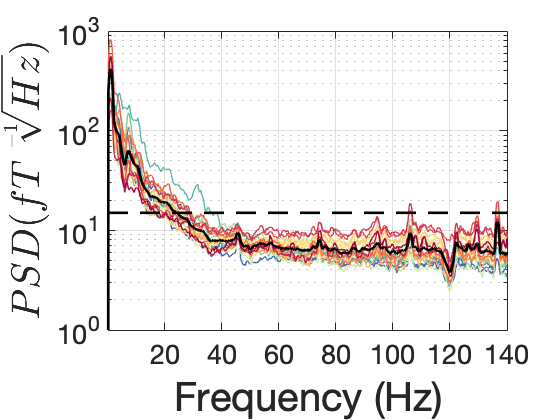

In [20]:
%% Spectral Interpolation
cfg                     = [];
cfg.channel             = 'all';
cfg.dftfilter           = 'yes';
cfg.dftfreq             = [37 50 83 100 120 150];
cfg.dftreplace          = 'neighbour';
cfg.dftbandwidth        = [2 3 2 2 3 2];
cfg.dftneighbourwidth   = [2 2 2 2 2 2];
rawData_MEG_dt_sg_si    = ft_preprocessing(cfg,rawData_MEG_dt_sg);

cfg                     = [];
cfg.channel             = 'all';
cfg.trial_length        = 3;
cfg.method              = 'tim';
cfg.foi                 = [0.2 140];
cfg.plot                = 'yes';
cfg.plot_legend         = 'no'
pow                     = ft_opm_psd(cfg,rawData_MEG_dt_sg_si);


Looks good :) 

There is a weird dip in the PSD at 120Hz, which is not optimal... but we are low-pass filtering at 40Hz later, so it shouldn't be too much of an issue

Calculating PSD for ALL channels
Calculating PSD for ALL channels


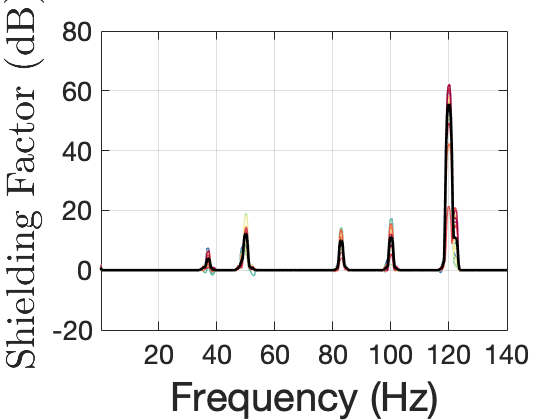

In [22]:
% Plot the Shielding Factor
cfg                 = [];
cfg.channel         = 'all';
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.2 140];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd_compare(cfg,rawData_MEG_dt_sg, rawData_MEG_dt_sg_si);

## Compute shielding factor before and after data cleaning 

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 49 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB


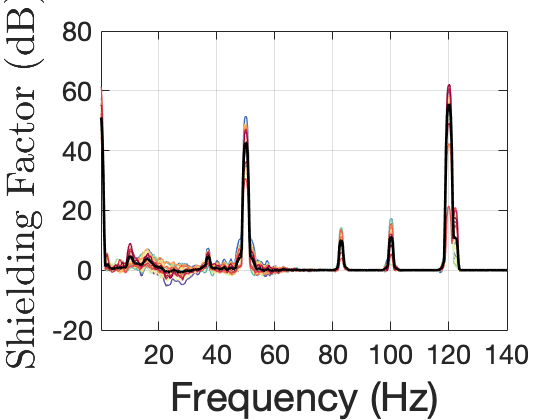

In [25]:
%% Compare before and after cleaning 
cfg                 = [];
cfg.channel         = vertcat(ft_channelselection_opm('MEG',rawData),...
     '-N3-RAD','-MV-RAD');
cfg.trial_length    = 3;
cfg.method          = 'tim';
cfg.foi             = [0.2 140];
cfg.plot            = 'yes';
cfg.plot_legend     = 'no';
pow                 = ft_opm_psd_compare(cfg,rawData_MEG, rawData_MEG_dt_sg_si);

## Low Pass Filter for smoooooth waveforms

In [28]:
%% Low-pass filter at 40Hz to remove large peaks
cfg                     = [];
cfg.lpfilter            = 'yes';
cfg.lpfreq              = 40;
rawData_MEG_dt_sg_si_lp = ft_preprocessing(cfg,rawData_MEG_dt_sg_si);

the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
preprocessing
preprocessing trial 1 from 1
the call to "ft_preprocessing" took 0 seconds and required the additional allocation of an estimated 101 MB


## Epoch the data

In [ ]:
cd([data_dir 'sub-002/ses-001/meg']);

cfg = [];
cfg.dataset                 = 'sub-002_ses-001_task-faces_run-001_meg.bin';
cfg.trialdef.trigchan       = 'FluxZ-B';
cfg.trialdef.downsample     = 300;
cfg.correct_time            = 0.1;
cfg.trialdef.prestim        = 0.5        % pre-stimulus interval
cfg.trialdef.poststim       = 0.7;        % post-stimulus interval
cfg.trialfun                = 'OPM_TrialFun_RS';
banana                      = ft_definetrial(cfg);

% Redefines the filtered data
cfg         = [];
data        = ft_redefinetrial(banana,rawData_MEG_dt_sg_si_lp);

%% Load the csv file to know which stimuli was on screen
csvfile     = readtable([data_dir 'M170_RS_run_1_20200226_1141.csv']);

% I made a mistake.. so you need to extract the identity of the stimuli
% from the csv file
stimfile    = csvfile.Stim_Path;
ddd         = [];

for s = 1:length(stimfile)
    xxx = split(stimfile{s},'\');
    if strcmp(xxx{2}(1),'f')
        ddd{s,1} = 'Famous';
    elseif strcmp(xxx{2}(1),'s')
        ddd{s,1} = 'Scrambled';
    elseif strcmp(xxx{2}(1),'u')
        ddd{s,1} = 'Unfamiliar';
    end
end

data.condition = ddd;


## Compute ERF

In [ ]:
cfg                 = [];
cfg.trials          = contains(data.condition,'Famous');
famous_faces        = ft_selectdata(cfg,data);
cfg.trials          = contains(data.condition,'Unfamiliar');
unfamiliar_faces    = ft_selectdata(cfg,data);
cfg.trials          = contains(data.condition,'Scrambled');
scrambled_faces     = ft_selectdata(cfg,data);

% Append the face data together
faces_all           = ft_appenddata([], famous_faces, unfamiliar_faces);

% Perform timelockanalysis
cfg             = [];
avg_faces_all   = ft_timelockanalysis([],faces_all);


#### Plot

the input is timelock data with 24 channels and 361 timebins
applying baseline correction on avg
the call to "ft_timelockbaseline" took 0 seconds and required the additional allocation of an estimated 0 MB

avg_faces_all = 

  struct with fields:

      time: [1�361 double]
     label: {24�1 cell}
      grad: [1�1 struct]
       avg: [24�361 double]
       dof: [24�361 double]
    dimord: 'chan_time'
       cfg: [1�1 struct]

the input is timelock data with 24 channels and 361 timebins
> In fixsampleinfo (line 94)
  In ft_datatype_timelock (line 147)
  In ft_checkdata (line 270)
  In ft_databrowser (line 294)
constructing single trial from "avg"
detected   0 visual artifacts
the call to "ft_databrowser" took 2 seconds and required the additional allocation of an estimated 6 MB


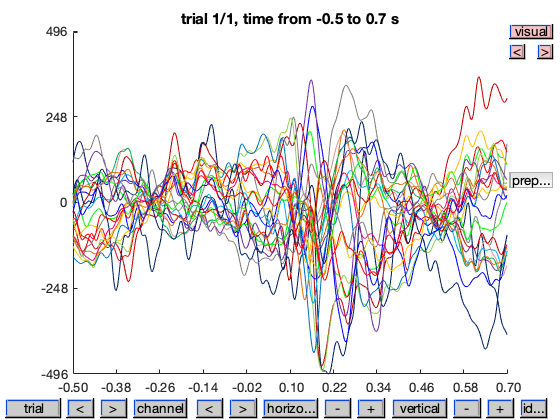

In [34]:
%% Plot all the channels avg in one plot
cfg             = [];
cfg.baseline    = [-0.5 0];
[avg_faces_all] = ft_timelockbaseline(cfg, avg_faces_all)

cfg             = [];
cfg.parameter   = 'avg';
ft_databrowser(cfg,avg_faces_all);

## Source Analysis

#### Load headmodel and sourcemodel computed previously

In [ ]:
%% Source Analysis
load([data_dir 'headmodel.mat']);
load([data_dir 'sourcemodel3d.mat']);

#### Compute covariance matrix on all data between -0.3 to 0.3s

In [ ]:
%% Compute covariance
cfg                  = [];
cfg.covariance       = 'yes';
cfg.vartrllength     = 2;
cfg.covariancewindow = [-0.3 0.3];
avg                  = ft_timelockanalysis(cfg,data);

#### Get grid position of MNI coordinate [-24 -72 8] expressed in the subject's MRI space. This coordinate was found using a whole-brain analysis previously performed.

In [ ]:
% Now we compute nonlinear warping between MNI and
mri = ft_read_mri([data_dir 'mmsMQ0484_orig.img']);
mri.coordsys = 'neuromag';

cfg             = [];
cfg.template    = mri;
cfg.nonlinear   = 'yes';
norm            = ft_volumenormalise([],mri);

pos = [-24 -72 8];

% Now we warp the MNI coordinates using the nonlinear warping parameters
posback         = ft_warp_apply(norm.params,pos,'sn2individual');
% xyz positions in individual coordinates
pos_grid        = ft_warp_apply(pinv(norm.initial),posback);


#### Compute leadfield at this grid point

 In '/Users/rseymoue/Documents/scripts/fieldtrip-20191213/utilities/ft_checkconfig.m' at line 128
 In '/Users/rseymoue/Documents/scripts/fieldtrip-20191213/ft_prepare_leadfield.m' at line 133

using gradiometers specified in the configuration
computing surface normals
creating sourcemodel based on user specified dipole positions
using gradiometers specified in the configuration
1 dipoles inside, 0 dipoles outside brain
the call to "ft_prepare_sourcemodel" took 3 seconds and required the additional allocation of an estimated 0 MB
computing leadfield
computing leadfield 1/1
the call to "ft_prepare_leadfield" took 9 seconds and required the additional allocation of an estimated 0 MB
 In '/Users/rseymoue/Documents/scripts/fieldtrip-20191213/plotting/ft_plot_vol.m' at line 11



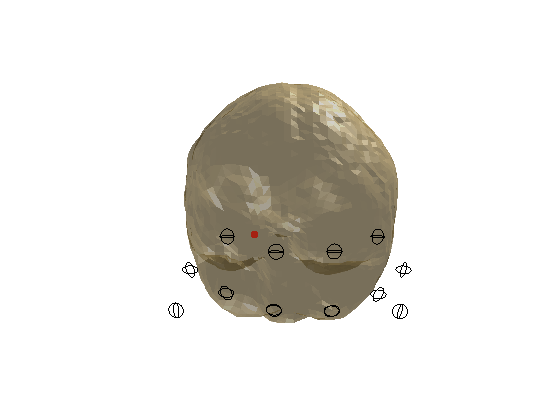

In [44]:
%% Prepare Leadfield
cfg = [];
cfg.method='lcmv';
cfg.channel = data.label;
cfg.grid.pos = pos_grid;
cfg.grid.unit = 'mm';
cfg.headmodel = headmodel;
cfg.grad = rawData.grad;
%cfg.reducerank      = 2; %(default = 3 for EEG, 2 for MEG)
cfg.normalize       = 'yes' ; %Normalise Leadfield: 'yes' for beamformer
%cfg.normalizeparam  = 1;
lf_2 = ft_prepare_leadfield(cfg);

% make a figure of the single subject{i} headmodel, and grid positions
figure; hold on;
ft_plot_vol(headmodel,  'facecolor', 'cortex', 'edgecolor', 'none');
alpha 0.5; camlight;
ft_plot_mesh(lf_2.pos(lf_2.inside,:),'vertexsize',20,'vertexcolor','r');
ft_plot_sens(rawData.grad, 'style', 'r*'); view([0,0]);

#### Perform source analysis using a beamformer and multiply the sensor-level data with the spatial filter

In [ ]:
cfg                    = [];
cfg.channel            = data.label;
cfg.grad               = rawData.grad;
cfg.method             = 'lcmv';
cfg.grid               = lf_2;
cfg.headmodel          = headmodel;
cfg.lcmv.keepfilter    = 'yes';
cfg.lcmv.fixedori      = 'yes';
cfg.lcmv.projectnoise  = 'yes';
%cfg.lcmv.weightnorm    = 'nai';
cfg.lcmv.lambda        = '5%';
sourceall              = ft_sourceanalysis(cfg, avg);

% Find filter from max point
filter = sourceall.avg.filter{1,1};

VE = [];
VE.label = {'max'};
VE.trialinfo = data.trialinfo;
VE.condition = data.condition;
for subs=1:(length(data.trialinfo))
    % note that this is the non-filtered "raw" data
    VE.time{subs}       = data.time{subs};
    VE.trial{subs}(1,:) = filter(1,:)*data.trial{subs}(:,:);
end

% Select data based on conditions
cfg                 = [];
cfg.trials          = contains(VE.condition,'Famous');
famous_faces        = ft_selectdata(cfg,VE);
cfg.trials          = contains(VE.condition,'Unfamiliar');
unfamiliar_faces    = ft_selectdata(cfg,VE);
cfg.trials          = contains(VE.condition,'Scrambled');
scrambled_faces     = ft_selectdata(cfg,VE);



#### Perform ERF analysis

In [ ]:
% Perform timelockanalysis
cfg             = [];
avg_famous      = ft_timelockanalysis([],famous_faces);
avg_unfamiliar  = ft_timelockanalysis([],unfamiliar_faces);
avg_scrambled   = ft_timelockanalysis([],scrambled_faces);

#### Plot!

the input is timelock data with 1 channels and 361 timebins
applying baseline correction on avg
baseline correction invalidates previous variance estimate, removing var
the call to "ft_timelockbaseline" took 0 seconds and required the additional allocation of an estimated 0 MB
the input is timelock data with 1 channels and 361 timebins
applying baseline correction on avg
baseline correction invalidates previous variance estimate, removing var
the call to "ft_timelockbaseline" took 0 seconds and required the additional allocation of an estimated 0 MB
the input is timelock data with 1 channels and 361 timebins
applying baseline correction on avg
baseline correction invalidates previous variance estimate, removing var
the call to "ft_timelockbaseline" took 0 seconds and required the additional allocation of an estimated 0 MB
the call to "ft_selectdata" took 0 seconds and required the additional allocation of an estimated 0 MB
the call to "ft_singleplotER" took 0 seconds and required the a

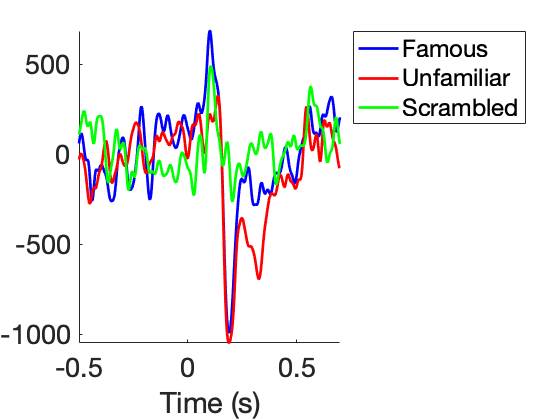

In [48]:
%% Plot
cfg = [];
cfg.parameter = 'avg';
cfg.baseline = [-0.5 0];
cfg.showlegend    = 'yes';
cfg.linewidth = 2;
%cfg.ylim = [-250 250];
figure; ft_singleplotER(cfg,avg_famous, avg_unfamiliar,...
    avg_scrambled);
legend({'Famous';'Unfamiliar';'Scrambled'},'Location','northeastoutside');
set(gca,'FontSize',20);
xlabel('Time (s)');
title('');